In [2]:
import pickle as cp
import numpy as np

X, y = cp.load(open('winequality-white.pickle','rb'))

N, num_features = X.shape
N_train = int(0.8 * N)
N_test = N - N_train
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

Handin 1 : 
Make a bar chart showing the distribution of y values appearing in the training set

<Container object of 7 artists>

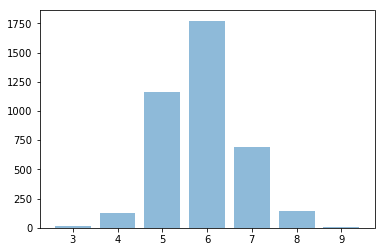

In [23]:
from scipy.stats import itemfreq
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
%matplotlib inline
plt.bar(unique, counts, align='center', alpha=0.5)


Handin 2 : Report the mean squared error, i.e., the average of the squared residuals

In [8]:
average = np.mean(y_train)
mse = np.mean((y_train - average)**2)
mse_test = np.mean((y_test- average)**2)
print ("Naive mse %f"%mse)
print ("Naive mse_test %f"%mse_test)

Naive mse 0.776777
Naive mse_test 0.813857


In [9]:
feature_mean = [] 
feature_std = [] 
for col in range(num_features):
    feature_val = X_train[:,col]
    mean = np.mean(feature_val)
    std = np.std(feature_val)
    std_feature = (feature_val - mean)/std 
    feature_mean.append(mean)
    feature_std.append(std)
    X_train[:,col] = std_feature 
    test_feature_val = X_test[:,col]
    std_test = (test_feature_val - mean)/std 
    X_test[:,col] = std_test

Closed-form Linear Regression Model 

In [10]:
from numpy.linalg import inv
ones = np.ones(len(X_train))
X_train_appended = np.column_stack((ones,X_train))
X_transpose = np.transpose(X_train_appended)
w = np.dot(np.dot(inv(np.dot(X_transpose, X_train_appended)),X_transpose),y_train)
y_predict = np.dot(X_train_appended,w)
mse = np.average((y_train - y_predict)**2)
print ("MSE for training data : %f"%mse)
X_test_appended = np.column_stack((np.ones(len(X_test)),X_test))
y_test_predict =  np.dot(X_test_appended,w)
mse_test = np.average((y_test - y_test_predict)**2)
print ("MSE for test data : %f"%mse_test)

MSE for training data : 0.564000
MSE for test data : 0.560729


Double Checking with sklearn 

In [11]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
#print('Coefficients: \n', regr.coef_)
predict = regr.predict(X_train)
print("Mean squared error for training data: %.2f"
      % mean_squared_error(y_train,predict ))
predict_test = regr.predict(X_test)
print("Mean squared error for test data: %.2f"
      % mean_squared_error(y_test,predict_test ))

Mean squared error for training data: 0.56
Mean squared error for test data: 0.56


Handin 4: Report the learning curves plot

In [12]:
datasets = 20 
max_datasets = 600
datapoints = []
training_error = []
testing_error = [] 

while (datasets <600): 
    X_train_batch = X_train_appended[:datasets,:]
    y_train_batch = y_train[:datasets]
    X_transpose = np.transpose(X_train_batch)
    w = np.dot(np.dot(inv(np.dot(X_transpose, X_train_batch)),X_transpose),y_train_batch)
    y_predict = np.dot(X_train_batch,w)
    mse = np.average((y_train_batch - y_predict)**2)
    training_error.append(mse)
    X_test = X_test_appended
    y_test_predict =  np.dot(X_test,w)
    mse_test = np.average((y_test - y_test_predict)**2)
    testing_error.append(mse_test)
    datasets = datasets + 20 
    datapoints.append(datasets)
    
%matplotlib inline
plt.plot(datapoints,training_error)
plt.plot(datapoints,testing_error)

plt.legend(['Training Error', 'Testing Error'], loc='upper right')


NameError: name 'plt' is not defined

I think the model is not underfitting. After getting around 250 data points the training error and testing error plateaus and that's the amount of data needed to get the optimal test error.  

In [27]:
lambda_list = [0.01,0.1,1,10,100 ]

X_train_new = X[:int(0.6*N)]
X_validation = X[int(0.6*N):int(0.8*N)]
y_train_new = y[:int(0.6*N)]
y_validation = y[int(0.6*N):int(0.8*N)]
X_train = X[:int(0.8*N)]
y_train = y[:int(0.8*N)]
X_test = X[int(0.8*N):]

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

optimal_ridges = [] 
optimal_lassos = []
poly_degrees = [2,3,4,5]
for poly_degree in poly_degrees: 
    print ('working with poly degree %d'%poly_degree)
    poly = PolynomialFeatures(poly_degree)
    X_train_new_poly = poly.fit_transform(X_train_new)
    X_validation_poly = poly.transform(X_validation)
    X_train_poly = poly.transform(X_train)
    X_test_poly = poly.transform(X_test)

    scaler = StandardScaler()
    X_transform = scaler.fit_transform(X_train_new_poly)
    X_validation_transform = scaler.transform(X_validation_poly)
    X_train_transform = scaler.transform(X_train_poly)
    X_test_transform = scaler.transform(X_test_poly)

    coefs_ridge = []
    ridge_mse_list = [] 
    for lam in lambda_list : 
        ridge = Ridge(alpha=lam)
        ridge.fit(X_transform, y_train_new) 
        y_validation_predict = ridge.predict(X_validation_transform)
        coefs_ridge.append(ridge.coef_)
        mse = mean_squared_error(y_validation,y_validation_predict)
        ridge_mse_list.append(mse)
     #   print ('lambda %f with mse %f '%(lam, mse))

    optimal_lam_ridge = lambda_list[ridge_mse_list.index(min(ridge_mse_list))]

    coefs_lasso = []
    lasso_mse_list = [] 
    for lam in lambda_list : 
        lasso = Lasso(alpha=lam)
        lasso.fit(X_transform, y_train_new) 
        y_validation_predict = lasso.predict(X_validation_transform)
        coefs_lasso.append(lasso.coef_)
        mse = mean_squared_error(y_validation,y_validation_predict)
        lasso_mse_list.append(mse)
    #    print ('lambda %f with mse %f '%(lam, mse))

    optimal_lam_lasso = lambda_list[lasso_mse_list.index(min(lasso_mse_list))]


    # running with optimal lambda for ridge 
    ridge = Ridge(alpha=optimal_lam_ridge)
    ridge.fit(X_train_transform, y_train) 
    y_test_predict = ridge.predict(X_test_transform)
    mse = mean_squared_error(y_test,y_test_predict)
    optimal_ridges.append(mse)
    print ('mse for ridge regression with optimal lambda %f : %f'%(optimal_lam_ridge,mse))

    # running with optimal lambda for lasso 
    lasso = Lasso(alpha=optimal_lam_lasso)
    lasso.fit(X_train_transform, y_train) 
    y_test_predict = lasso.predict(X_test_transform)
    mse = mean_squared_error(y_test,y_test_predict)
    optimal_lassos.append(mse)
    print ('mse for lasso regression with optimal lambda %f : %f'%(optimal_lam_lasso,mse))


print ('optimal for ridge is degre %d with mse %f'%(poly_degrees[optimal_ridges.index(min(optimal_ridges))], min(optimal_ridges)))
print ('optimal for lasso is degre %d with mse %f'%(poly_degrees[optimal_lassos.index(min(optimal_lassos))],min(optimal_lassos)))
# Plotting ... 
#    %matplotlib inline
#    ax = plt.gca()

#    ax.plot(lambda_list, coefs_ridge)
#    ax.set_xscale('log')
#    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#    plt.xlabel('alpha')
#    plt.ylabel('weights')
#    plt.title('Ridge coefficients as a function of the regularization')
#    plt.axis('tight')
#    plt.show()

#    %matplotlib inline
#    ax2 = plt.gca()
#    ax2.plot(lambda_list, coefs_lasso)
#    ax2.set_xscale('log')
#    ax2.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#    plt.xlabel('alpha')
#    plt.ylabel('weights')
#    plt.title('Lasso coefficients as a function of the regularization')
#    plt.axis('tight')
#    plt.show()


working with poly degree 2
mse for ridge regression with optimal lambda 1.000000 : 0.512589
mse for lasso regression with optimal lambda 0.010000 : 0.527511
working with poly degree 3
mse for ridge regression with optimal lambda 100.000000 : 0.599301
mse for lasso regression with optimal lambda 0.010000 : 0.514302
working with poly degree 4
mse for ridge regression with optimal lambda 100.000000 : 1.087639
mse for lasso regression with optimal lambda 0.010000 : 0.521606
working with poly degree 5
mse for ridge regression with optimal lambda 100.000000 : 1.597427
mse for lasso regression with optimal lambda 0.010000 : 0.508657
optimal for ridge is degre 2 with mse 0.512589
optimal for lasso is degre 5 with mse 0.508657


According to the Results, per the combinations tried, the optimal configuration for ridge regressino is degree 2 with lambda 1 and the optimal configuration for lasso is degree 5 with lambda 0.01